<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Macros/BackgroundEstimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init and cuts definition

In [8]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
h5file='drive/MyDrive/root_files_cry4/cry4df.h5'

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)
sys.path.append(main_path+'root_files_cry4')
from utils import Utils
util = Utils()
import math

plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.7
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
TMIN = -125
TMAX = 50
PMIN_EXT = 90
PMAX_EXT = 140
PMIN_PHY = 103.85
PMAX_PHY = 105.1


#Default MDC-style cut box
cuts = [
    "(de_status > 0)",
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 105)",
    "((deent_d0 + 2./deent_om) > 450)",
    "((deent_d0 + 2./deent_om) < 680)",
    "(is_triggered)"
]
cut_tbox = " & ".join(cuts)

#PID, TrkQual and cut on events with an usptream leg
cuts = [
    "(dequal_TrkQual > 0.8)",
    "(dequal_TrkPID > 0.95)",
    "(ue_status <= 0)"
]
cut_pid_trkqual_ue = " & ".join(cuts)

# Extended momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_EXT,
    "(deent_mom < %f)" % PMAX_EXT
]
cut_extmom = " & ".join(cuts)

# Physics momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_PHY,
    "(deent_mom < %f)" % PMAX_PHY,
]
cut_phymom = " & ".join(cuts)

# Loose box cuts
cuts = [
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 205)",
    "((deent_d0 + 2./deent_om) > 450)",
    "(is_triggered)"
]
cut_lbox = " & ".join(cuts)


crv_time = "( crvinfo__dT < %d | crvinfo__dT > %d)" % (TMIN, TMAX)
#Combime cuts
cut_nomom  = cut_tbox +" & "+cut_pid_trkqual_ue
cut_extmom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_extmom
cut_phymom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_phymom
cut_loose  = cut_lbox +" & "+cut_pid_trkqual_ue

cut_current = cut_extmom+" & "+crv_time

#Load dataframe

In [3]:
df = pd.read_hdf(h5file, mode='r')

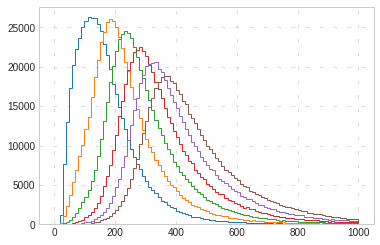

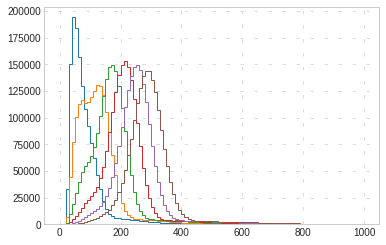

In [4]:
for l in range(7000,17001,2000):
  plt.hist(df.query('is_high==1 & lyield==%i' % l)['crvinfo__PEs'], bins=100, range=(0, 1000), histtype='step');
plt.figure()
for l in range(7000,17001,2000):
  plt.hist(df.query('is_high==0 & lyield==%i' % l)['crvinfo__PEs'], bins=100, range=(0, 1000), histtype='step');

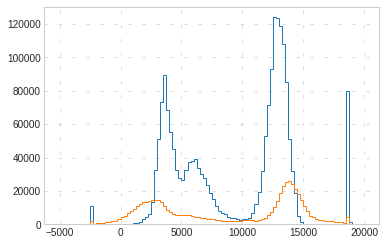

In [5]:
plt.hist(df.query('is_high==0 & lyield==%i' % 17000)['_z'], bins=100, range=(-5000, 20000), histtype='step');
plt.hist(df.query('is_high==1 & lyield==%i' % 17000)['_z'], bins=100, range=(-5000, 20000), histtype='step');

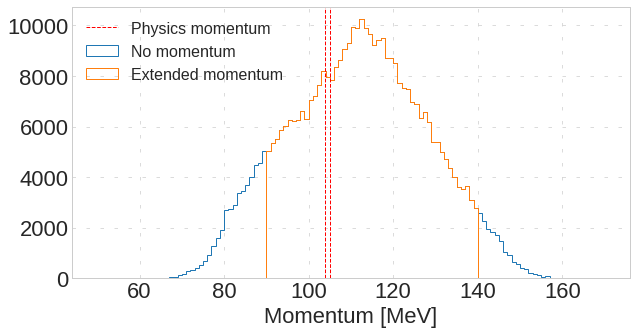

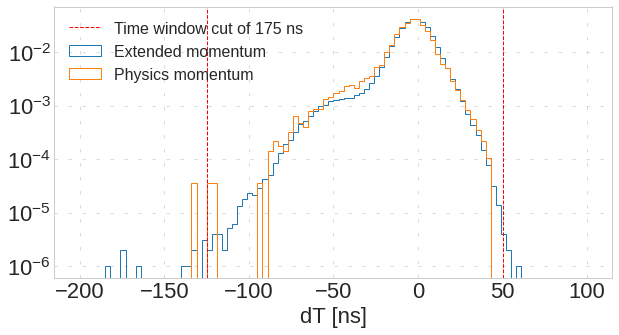

In [56]:
neve_extmom = len(df.query(cut_extmom))
neve_physmom = len(df.query(cut_phymom))
mom_scale = neve_extmom/neve_physmom
label = r'$\frac{P_{ext}}{P_{phy}} = %.1f$' % mom_scale
_, bins, _ = plt.hist(df.query(cut_nomom)['deent_mom'], bins=120, range=[50, 170], histtype='step', label='No momentum');
plt.hist(df.query(cut_extmom)['deent_mom'], bins=bins, histtype='step', label='Extended momentum');
plt.axvline(PMIN_PHY, color='r', linestyle='--', linewidth=1)
plt.axvline(PMAX_PHY, color='r', linestyle='--', label='Physics momentum', linewidth=1)
plt.legend(loc='upper left', prop={'size': 16})
plt.xlabel('Momentum [MeV]')

plt.figure()
plt.hist(df.query(cut_extmom)['crvinfo__dT'], bins=100, range=(-200, 100), histtype='step', density=True, label='Extended momentum');
plt.hist(df.query(cut_phymom)['crvinfo__dT'], bins=100, range=(-200, 100), histtype='step', density=True, label='Physics momentum');
plt.axvline(tmin, color='r', linestyle='--', linewidth=1)
plt.axvline(tmax, color='r', linestyle='--', linewidth=1, label='Time window cut of 175 ns')
plt.yscale('log')
plt.xlabel('dT [ns]');
plt.legend(loc='upper left', prop={'size': 16})

In [53]:
util = Utils()
util.pritnLiveTimes()

LIVETIME_MU2E: 3.460000e+06
LIVETIME_HI: 5.490000e+06
LIVETIME_LO: 1.869000e+08


#Background estimation: production sources

In [57]:
def plot_background(cut_query, title, altitude_scale, log_scale=True, make_plot=True):

  lyield_scale=0.001726
  bg_ave = []
  pe_ave = []
  bg_err = []
  print(title)

  for ly in range(7000,17001,2000):
    bg = util.getNormBackground(df, cut_query+" & lyield =="+str(ly), mom_scale)
    bg_ave.append(bg[0]*altitude_scale)
    pe_ave.append(ly*lyield_scale)
    bg_err.append(bg[1]*math.sqrt(altitude_scale))
    print("PE: %.1f, bg: %3.4f, err: %3.4f" % (ly*lyield_scale, bg[0]*altitude_scale, bg[1]))

  plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.k');
  plt.title(title)
  if log_scale:
    plt.yscale('log')
  return (bg_ave, pe_ave, bg_err)

Muons inside CRV
PE: 12.1, bg: 16.2805, err: 0.3951
PE: 15.5, bg: 3.1200, err: 0.1585
PE: 19.0, bg: 0.5211, err: 0.0527
PE: 22.4, bg: 0.1054, err: 0.0192
PE: 25.9, bg: 0.0683, err: 0.0257
PE: 29.3, bg: 0.0267, err: 0.0181
Non-muons
PE: 12.1, bg: 0.0545, err: 0.0049
PE: 15.5, bg: 0.0469, err: 0.0045
PE: 19.0, bg: 0.0463, err: 0.0045
PE: 22.4, bg: 0.0463, err: 0.0045
PE: 25.9, bg: 0.0463, err: 0.0045
PE: 29.3, bg: 0.0475, err: 0.0046
Muons outside CRV
PE: 12.1, bg: 0.0227, err: 0.0034
PE: 15.5, bg: 0.0111, err: 0.0024
PE: 19.0, bg: 0.0100, err: 0.0022
PE: 22.4, bg: 0.0100, err: 0.0022
PE: 25.9, bg: 0.0105, err: 0.0023
PE: 29.3, bg: 0.0094, err: 0.0022


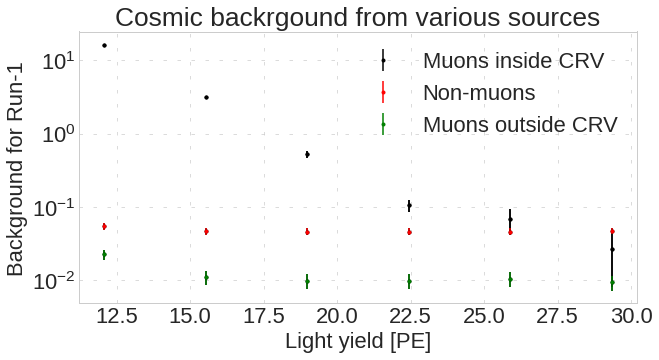

In [58]:
title='Muons inside CRV'
bg_ave, pe_ave, bg_err = plot_background(cut_current+" & _crvSectorType > 0 & abs(demcgen_pdg) == 13", title, 1.05, False, False)
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.k', label=title)

title = 'Non-muons'
bg_ave, pe_ave, bg_err = plot_background(cut_current+" & abs(demcgen_pdg) != 13", title, 1.2, False, False)
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.r', label=title)

title = 'Muons outside CRV'
bg_ave, pe_ave, bg_err = plot_background(cut_current+" & _crvSectorType < 0 & abs(demcgen_pdg) == 13", title, 1.05, False, False)
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.g', label=title)
plt.legend()
plt.yscale('log');
plt.title('Cosmic backrgound from various sources');
plt.xlabel('Light yield [PE]')
plt.ylabel('Background for Run-1');

#Background estimation: CRV regions

Background from muons inside the fiducial CRV region
PE: 12.1, bg: 16.2805, err: 0.3951
PE: 15.5, bg: 3.1200, err: 0.1585
PE: 19.0, bg: 0.5211, err: 0.0527
PE: 22.4, bg: 0.1054, err: 0.0192
PE: 25.9, bg: 0.0683, err: 0.0257
PE: 29.3, bg: 0.0267, err: 0.0181
Background from muons outside of fiducial CRV region
PE: 12.1, bg: 0.0227, err: 0.0034
PE: 15.5, bg: 0.0111, err: 0.0024
PE: 19.0, bg: 0.0100, err: 0.0022
PE: 22.4, bg: 0.0100, err: 0.0022
PE: 25.9, bg: 0.0105, err: 0.0023
PE: 29.3, bg: 0.0094, err: 0.0022
Background from non-muons
PE: 12.1, bg: 0.0545, err: 0.0049
PE: 15.5, bg: 0.0469, err: 0.0045
PE: 19.0, bg: 0.0463, err: 0.0045
PE: 22.4, bg: 0.0463, err: 0.0045
PE: 25.9, bg: 0.0463, err: 0.0045
PE: 29.3, bg: 0.0475, err: 0.0046


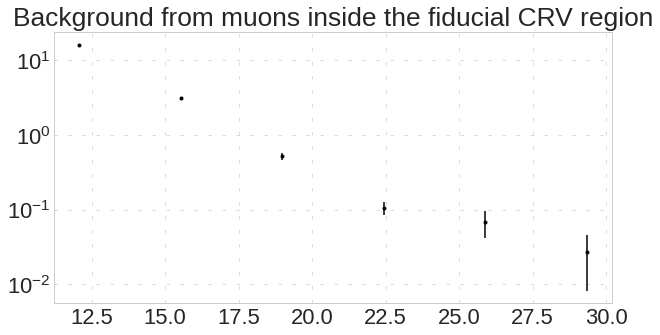

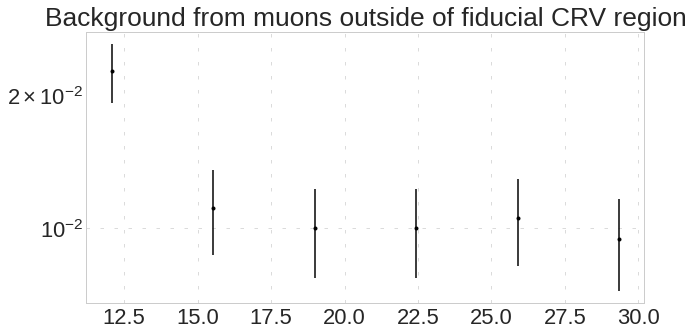

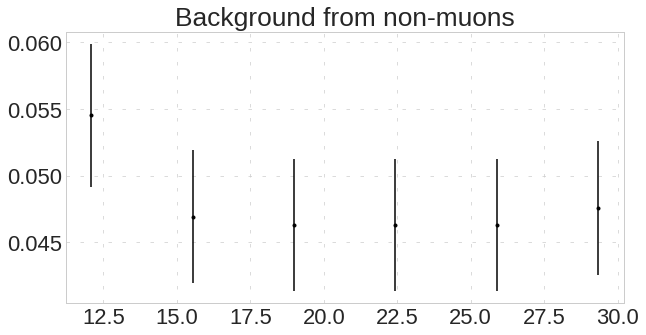

In [62]:
title='Background from muons inside the fiducial CRV region'
plot_background(cut_current+" & _crvSectorType > 0 & abs(demcgen_pdg) == 13", title, 1.05)

plt.figure()
title = 'Background from muons outside of fiducial CRV region'
plot_background(cut_current+" & _crvSectorType < 0 & abs(demcgen_pdg) == 13", title, 1.05)

plt.figure()
title = 'Background from non-muons'
plot_background(cut_current+" & abs(demcgen_pdg) != 13", title, 1.2, False);

Background from sector R
PE: 12.1, bg: 0.0827, err: 0.0314
PE: 15.5, bg: 0.0111, err: 0.0024
PE: 19.0, bg: 0.0044, err: 0.0015
PE: 22.4, bg: 0.0011, err: 0.0007
PE: 25.9, bg: 0.0017, err: 0.0009
PE: 29.3, bg: 0.0011, err: 0.0007
Background from sector L
PE: 12.1, bg: 0.0067, err: 0.0018
PE: 15.5, bg: 0.0011, err: 0.0007
PE: 19.0, bg: 0.0000, err: 0.0000
PE: 22.4, bg: 0.0000, err: 0.0000
PE: 25.9, bg: 0.0000, err: 0.0000
PE: 29.3, bg: 0.0000, err: 0.0000
Background from sector T
PE: 12.1, bg: 16.1284, err: 0.3926
PE: 15.5, bg: 3.1044, err: 0.1585
PE: 19.0, bg: 0.5161, err: 0.0526
PE: 22.4, bg: 0.1021, err: 0.0191
PE: 25.9, bg: 0.0661, err: 0.0257
PE: 29.3, bg: 0.0250, err: 0.0181
Background from sector E
PE: 12.1, bg: 0.0006, err: 0.0005
PE: 15.5, bg: 0.0006, err: 0.0005
PE: 19.0, bg: 0.0006, err: 0.0005
PE: 22.4, bg: 0.0006, err: 0.0005
PE: 25.9, bg: 0.0006, err: 0.0005
PE: 29.3, bg: 0.0006, err: 0.0005
Background from sector U
PE: 12.1, bg: 0.0189, err: 0.0180
PE: 15.5, bg: 0.0000, er

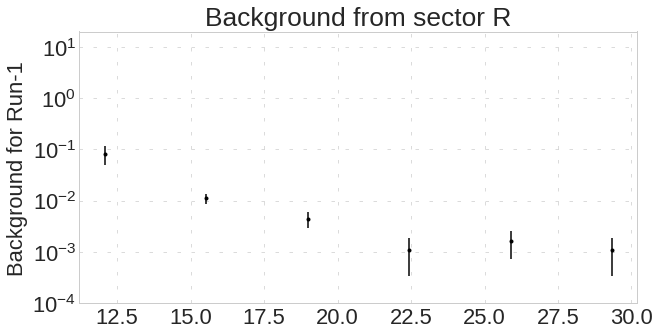

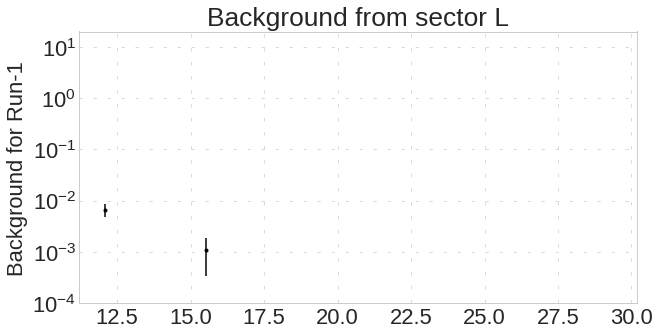

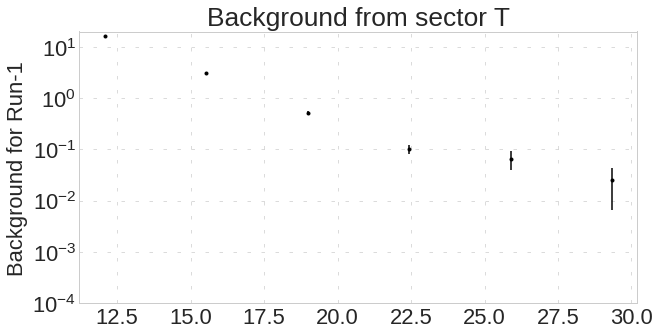

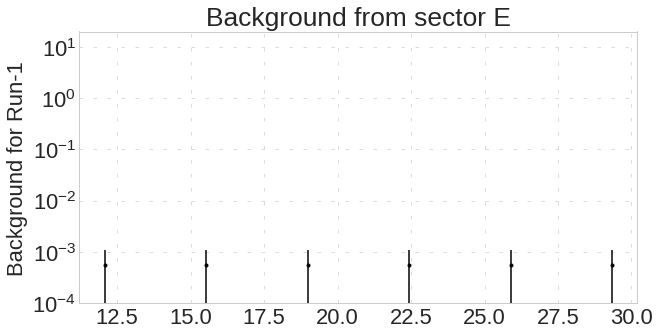

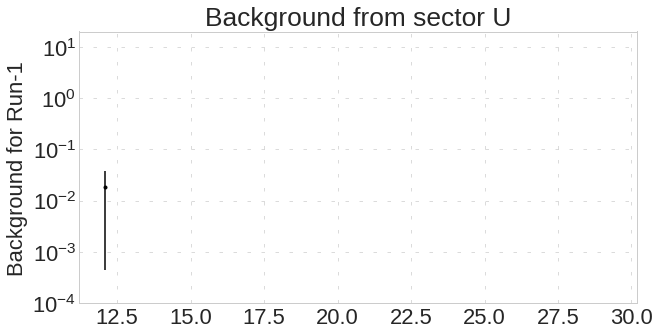

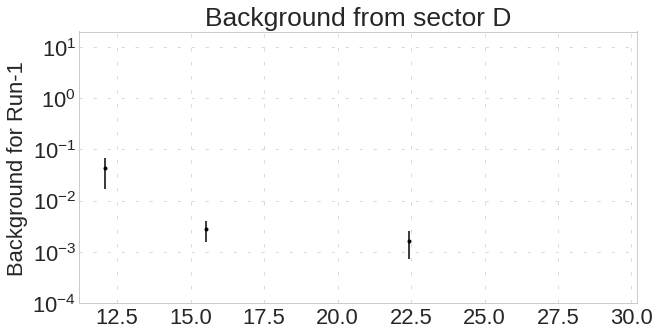

In [68]:
crvSectorLabel = ['R', 'L', 'T', 'E', 'U', 'D']
for crvSectorType in range(1,7):
  plt.figure()
  title='Background from sector %s' % crvSectorLabel[crvSectorType-1]
  cut_ = cut_current+(" & _crvSectorType ==%d  & abs(demcgen_pdg) == 13" % crvSectorType)
  plot_background(cut_, title, 1.05)
  plt.ylim(0.0001, 20)
  plt.ylabel('Background for Run-1')